In [1]:
import MDAnalysis as mda

/home/louis/miniconda3/envs/Plot_RNA/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
u = mda.Universe("test_files/frame_0_noions.pdb", "test_files/traj_0_80000.xtc")

In [3]:
from MDAnalysis.analysis.nuclinfo import tors

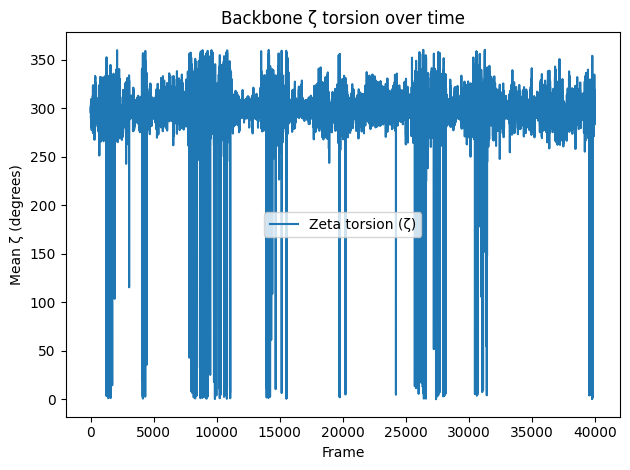

In [29]:
import MDAnalysis as mda
from MDAnalysis.analysis.nuclinfo import tors
import numpy as np

def circular_mean(angles_deg):
    angles_rad = np.radians(angles_deg)
    sin_sum = np.sum(np.sin(angles_rad))
    cos_sum = np.sum(np.cos(angles_rad))
    mean_angle_rad = np.arctan2(sin_sum, cos_sum)
    mean_angle_deg = np.degrees(mean_angle_rad) % 360
    R = np.sqrt(sin_sum**2 + cos_sum**2) / len(angles_rad)
    circular_variance = 1 - R
    return mean_angle_deg, circular_variance

# Load RNA trajectory
u = mda.Universe("test_files/frame_0_noions.pdb", "test_files/traj_0_80000.xtc")
segid = "C1"

# Initialize frame-wise torsion data
torsion_data = {
    'alpha': [],
    'beta': [],
    'gamma': [],
    'delta': [],
    'epsilon': [],
    'zeta': [],
    'chi': []
}

# Loop over frames
for ts in u.trajectory:
    # Per-frame storage
    frame_torsions = {
        'alpha': [], 'beta': [], 'gamma': [],
        'delta': [], 'epsilon': [], 'zeta': [], 'chi': []
    }

    # Loop over residues in current frame
    for res in u.select_atoms(f"segid {segid}").residues:
        try:
            alpha, beta, gamma, delta, epsilon, zeta, chi = tors(u, segid, res.resid)
            frame_torsions['alpha'].append(alpha)
            frame_torsions['beta'].append(beta)
            frame_torsions['gamma'].append(gamma)
            frame_torsions['delta'].append(delta)
            frame_torsions['epsilon'].append(epsilon)
            frame_torsions['zeta'].append(zeta)
            frame_torsions['chi'].append(chi)
        except Exception as e:
            continue  # skip missing/invalid residues silently

    # Aggregate circular mean per angle per frame
    for key in torsion_data:
        if frame_torsions[key]:
            mean_angle, _ = circular_mean(frame_torsions[key])
            torsion_data[key].append(mean_angle)
        else:
            torsion_data[key].append(np.nan)

# ✅ Example output: plot ζ torsion over time
import matplotlib.pyplot as plt

plt.plot(torsion_data['zeta'], label='Zeta torsion (ζ)')
plt.xlabel('Frame')
plt.ylabel('Mean ζ (degrees)')
plt.title('Backbone ζ torsion over time')
plt.legend()
plt.tight_layout()
plt.show()




In [25]:
import numpy as np
def circular_mean(angles_deg):
    """Compute circular mean and variance of angles (degrees)."""
    angles_rad = np.radians(angles_deg)
    sin_sum = np.sum(np.sin(angles_rad))
    cos_sum = np.sum(np.cos(angles_rad))
    mean_angle_rad = np.arctan2(sin_sum, cos_sum)
    mean_angle_deg = np.degrees(mean_angle_rad) % 360
    R = np.sqrt(sin_sum**2 + cos_sum**2) / len(angles_rad)
    circular_variance = 1 - R
    return mean_angle_deg, circular_variance

print("Backbone Torsion Circular Statistics:")
for name, angles in torsion_data.items():
    if angles:
        mean, var = circular_mean(angles)
        print(f"{name:7s} — Mean: {mean:6.2f}°, Variance: {var:.4f}")
    else:
        print(f"{name:7s} — No valid data")


Backbone Torsion Circular Statistics:
alpha   — Mean: 273.23°, Variance: 0.1702
beta    — Mean: 168.80°, Variance: 0.0180
gamma   — Mean:  69.31°, Variance: 0.0053
delta   — Mean:  79.16°, Variance: 0.0072
epsilon — Mean: 209.90°, Variance: 0.0202
zeta    — Mean: 296.41°, Variance: 0.0061
chi     — Mean: 199.33°, Variance: 0.0061


Backbone Torsion Circular Statistics:
alpha   — Mean: 273.23°, Variance: 0.1702
beta    — Mean: 168.80°, Variance: 0.0180
gamma   — Mean:  69.31°, Variance: 0.0053
delta   — Mean:  79.16°, Variance: 0.0072
epsilon — Mean: 209.90°, Variance: 0.0202
zeta    — Mean: 296.41°, Variance: 0.0061
chi     — Mean: 199.33°, Variance: 0.0061


IndexError: index 2 is out of bounds for axis 0 with size 2

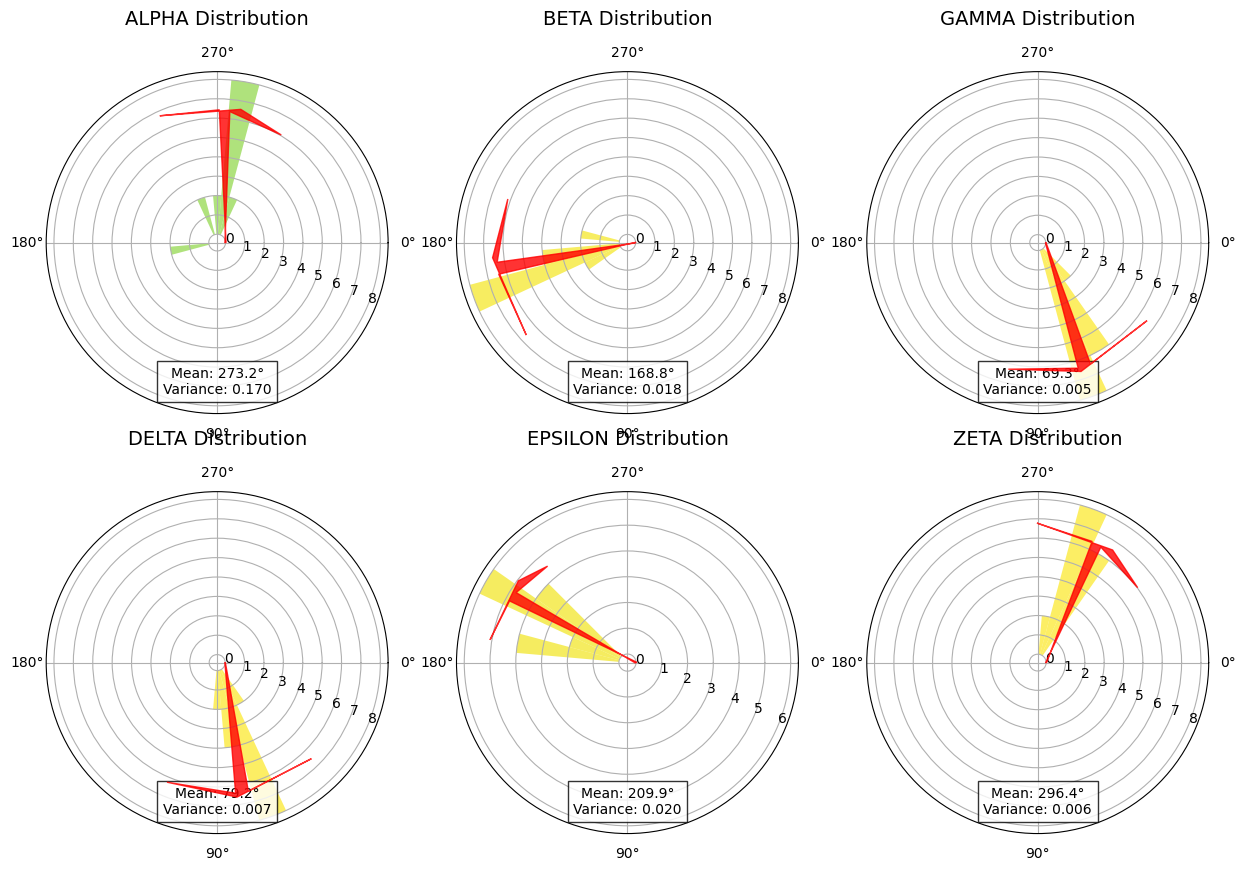

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
# Calculate statistics for each torsion angle
torsion_stats = {}
print("Backbone Torsion Circular Statistics:")
for name, angles in torsion_data.items():
    if len(angles) > 0:
        mean, var = circular_mean(angles)
        torsion_stats[name] = {"mean": mean, "variance": var, "data": angles}
        print(f"{name:7s} — Mean: {mean:6.2f}°, Variance: {var:.4f}")
    else:
        print(f"{name:7s} — No valid data")

# Visualization
plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=plt.gcf())

# Color scheme
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=1)

# Create plots
for i, (name, stats) in enumerate(torsion_stats.items()):
    row, col = i // 3, i % 3
    ax = plt.subplot(gs[row, col], projection='polar')
    
    # Convert to radians for plotting
    angles_rad = np.radians(stats['data'])
    mean_rad = np.radians(stats['mean'])
    
    # Histogram
    bins = np.linspace(0, 2*np.pi, 37)  # 36 bins (10° each)
    hist, _ = np.histogram(angles_rad, bins=bins)
    width = 2*np.pi / 36
    bars = ax.bar(bins[:-1], hist, width=width, alpha=0.7, 
                 color=cmap(1-stats['variance']))
    
    # Add mean vector
    ax.arrow(0, 0, mean_rad, max(hist)*0.8, alpha=0.8, width=0.1,
            head_width=max(hist)*0.15, head_length=0.2, 
            edgecolor='red', facecolor='red', zorder=5)
    
    # Customize plot
    ax.set_title(f"{name.upper()} Distribution", fontsize=14, pad=15)
    ax.set_theta_zero_location("E")  # 0° at the right
    ax.set_theta_direction(-1)  # clockwise
    
    # Add custom degree labels (0°, 90°, 180°, 270°)
    ax.set_xticks(np.radians([0, 90, 180, 270]))
    ax.set_xticklabels(['0°', '90°', '180°', '270°'], fontsize=10)
    
    # Add text with statistics
    stat_text = f"Mean: {stats['mean']:.1f}°\nVariance: {stats['variance']:.3f}"
    ax.text(0.5, 0.05, stat_text, transform=ax.transAxes, 
           horizontalalignment='center', verticalalignment='bottom',
           bbox=dict(facecolor='white', alpha=0.8))

# Create a color bar showing variance scale
cax = plt.subplot(gs[:, -1])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.set_label('Concentration (1 - Variance)', fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for colorbar

# Add legend explaining the plot elements
red_arrow = mpatches.Patch(color='red', label='Mean direction')
blue_hist = mpatches.Patch(color=cmap(0.5), label='Angle distribution')
plt.legend(handles=[red_arrow, blue_hist], 
          loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=2, fontsize=12)

plt.suptitle('Backbone Torsion Angle Distributions', fontsize=18, y=0.98)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust for title and colorbar

plt.show()

In [31]:
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio

# Set plotly to render in notebook if you're using one
# init_notebook_mode(connected=True)
# Or use a different renderer as needed
pio.renderers.default = "browser"  # or "notebook", "colab", etc.

def circular_mean(angles_deg):
    """Compute circular mean and variance of angles (degrees)."""
    angles_rad = np.radians(angles_deg)
    sin_sum = np.sum(np.sin(angles_rad))
    cos_sum = np.sum(np.cos(angles_rad))
    mean_angle_rad = np.arctan2(sin_sum, cos_sum)
    mean_angle_deg = np.degrees(mean_angle_rad) % 360
    R = np.sqrt(sin_sum**2 + cos_sum**2) / len(angles_rad)
    circular_variance = 1 - R
    return mean_angle_deg, circular_variance


# Calculate statistics for each torsion angle
torsion_stats = {}
print("Backbone Torsion Circular Statistics:")
for name, angles in torsion_data.items():
    if len(angles) > 0:
        mean, var = circular_mean(angles)
        torsion_stats[name] = {"mean": mean, "variance": var, "data": angles}
        print(f"{name:7s} — Mean: {mean:6.2f}°, Variance: {var:.4f}")
    else:
        print(f"{name:7s} — No valid data")

# Create a 2x3 subplot figure
fig = sp.make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}],
           [{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=[f"{name.upper()}" for name in torsion_stats.keys()]
)

# Color scheme setup
colorscale = px.colors.sequential.Viridis

# Create polar plots
for i, (name, stats) in enumerate(torsion_stats.items()):
    row, col = i // 3 + 1, i % 3 + 1
    
    # Convert to radians for calculation but keep in degrees for display
    data = stats['data']
    mean_angle = stats['mean']
    variance = stats['variance']
    concentration = 1 - variance
    
    # Create histogram data
    bins = np.linspace(0, 360, 37)  # 36 bins (10° each)
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Map concentration to color
    color_idx = int(concentration * (len(colorscale) - 1))
    bar_color = colorscale[color_idx]
    
    # Add histogram trace
    fig.add_trace(
        go.Barpolar(
            r=hist,
            theta=bin_centers,
            width=10,
            marker_color=bar_color,
            opacity=0.7,
            hoverinfo="text",
            hovertext=[f"Range: {bin_edges[i]:.1f}° - {bin_edges[i+1]:.1f}°<br>Count: {hist[i]}" 
                      for i in range(len(hist))],
            name=f"{name} distribution"
        ),
        row=row, col=col
    )
    
    # Add marker for mean direction
    # We'll use a polar scatter point with a larger marker
    fig.add_trace(
        go.Scatterpolar(
            r=[max(hist) * 0.8],
            theta=[mean_angle],
            mode='markers',
            marker=dict(
                symbol='arrow',
                size=20,
                color='red',
                line=dict(color='black', width=1)
            ),
            name=f"{name} mean",
            hoverinfo="text",
            hovertext=f"Mean: {mean_angle:.2f}°<br>Variance: {variance:.4f}"
        ),
        row=row, col=col
    )
    
    # Add statistics as annotations
    fig.add_annotation(
        text=f"Mean: {mean_angle:.1f}°<br>Variance: {variance:.3f}<br>N = {len(data)}",
        x=0.5, y=0.15,
        xref=f"x{i+1} domain", yref=f"y{i+1} domain",
        showarrow=False,
        font=dict(size=12, color="black"),
        bgcolor="white",
        opacity=0.8,
        bordercolor="black",
        borderwidth=1,
        borderpad=4
    )
    
    # Update polar axes layout
    fig.update_layout(**{
        f"polar{i+1 if i > 0 else ''}": dict(
            radialaxis=dict(showticklabels=False, ticks=''),
            angularaxis=dict(
                direction="clockwise",
                rotation=90,  # Start at East (0 degrees)
                tickmode="array",
                tickvals=[0, 90, 180, 270],
                ticktext=["0°", "90°", "180°", "270°"]
            )
        )
    })

# Update overall layout
fig.update_layout(
    title={
        'text': "Backbone Torsion Angle Distributions",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    showlegend=False,
    height=800,
    width=1200,
    margin=dict(l=20, r=20, t=100, b=20)
)

# Add a colorbar
colorbar_trace = go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(
        colorscale=colorscale,
        showscale=True,
        cmin=0,
        cmax=1,
        colorbar=dict(
            title='Concentration<br>(1 - Variance)',
            x=1.05,
            xanchor='left'
        )
    ),
    hoverinfo='none'
)
fig.add_trace(colorbar_trace)

# Create Ramachandran plot if phi and psi exist
if 'phi' in torsion_data and 'psi' in torsion_data:
    # Create a new figure for the Ramachandran plot
    rama_fig = go.Figure()
    
    # Convert angles to -180 to 180 range for traditional Ramachandran plot
    phi_data = (torsion_data['phi'] - 180) % 360 - 180
    psi_data = (torsion_data['psi'] - 180) % 360 - 180
    
    # Add scatter plot
    rama_fig.add_trace(go.Scatter(
        x=phi_data,
        y=psi_data,
        mode='markers',
        marker=dict(
            color=colorscale[int(0.7 * (len(colorscale) - 1))],
            size=10,
            opacity=0.7,
            line=dict(width=1, color='black')
        ),
        hoverinfo="text",
        hovertext=[f"Phi: {phi:.2f}°<br>Psi: {psi:.2f}°" for phi, psi in zip(phi_data, psi_data)]
    ))
    
    # Add mean point
    phi_mean = (torsion_stats['phi']['mean'] - 180) % 360 - 180
    psi_mean = (torsion_stats['psi']['mean'] - 180) % 360 - 180
    
    rama_fig.add_trace(go.Scatter(
        x=[phi_mean],
        y=[psi_mean],
        mode='markers',
        marker=dict(
            symbol='star',
            size=20,
            color='red',
            line=dict(color='black', width=1)
        ),
        name='Mean',
        hoverinfo="text",
        hovertext=f"Mean Phi: {phi_mean:.2f}°<br>Mean Psi: {psi_mean:.2f}°"
    ))
    
    # Update layout
    rama_fig.update_layout(
        title="Ramachandran Plot (Phi-Psi Distribution)",
        xaxis=dict(
            title="Phi (°)",
            range=[-180, 180],
            zeroline=True,
            zerolinecolor='black',
            zerolinewidth=1
        ),
        yaxis=dict(
            title="Psi (°)",
            range=[-180, 180],
            zeroline=True,
            zerolinecolor='black',
            zerolinewidth=1
        ),
        showlegend=True,
        width=800,
        height=700
    )
    
    # Add grid lines
    rama_fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    rama_fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

    # Show the Ramachandran plot
    rama_fig.show()

# Show the main figure with polar plots
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [21]:
!pip install pandas

  Using cached pandas-2.2.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]
